In [28]:
import pandas as pd
import numpy as np
import os,fnmatch
import xarray as xr
import matplotlib.pylab as plt
from matplotlib import rcParams
from functools import reduce
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['font.size']=13

In [2]:
# Making exception when loading text files
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
# Loding the basline
bl_len = pd.read_csv('/data/isaac/DR1/meerkatbaselinelengh.csv')
bl_len = bl_len.iloc[:,1:].values[0]
# Baseline index sorted by ascending order
indx = np.argsort(bl_len)
bl_len = bl_len[indx]

In [109]:
# Loading DR0 and DR1 montly mean per baseline
dr1 = np.load('/data/isaac/DR1/montl_mean__per_bl.npy')
dr0= np.load('/data/isaac/DR0/montly_per_bl_mean.py.npy')

In [110]:
def data_to_use(dr0,dr1,d0=False,d1=False,both=False):
    '''
    Input : dr0,dr1 mean per baseline
    
    Output : Dataset combination or dr1 or dr0
    '''
    Data = []
    data1 = []
    for i in range(len(dr1)):
        Data.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        data1.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        
    for i in range(len(dr0)):
        Data.append([dr0[i][0],dr0[i][1],dr0[i][2]])
    if d0:
        return dr0
    if d1:
        return data1
    if both:
        return Data
        
    

In [111]:
Data = data_to_use(dr0,dr1,both=True,d1=False,d0=False)

In [112]:
mon = []
tim = []
bl_mean = []
for i in range(len(Data)):
    if str(Data[i][2])[4]=='0':
        mon.append(float(str(Data[i][2])[5]))
        bl_mean.append(Data[i][0].astype(float))
        tim.append(Data[i][1])
    else:
        mon.append(float(str(Data[i][2])[4:6]))
        bl_mean.append(Data[i][0].astype(float))
        tim.append(Data[i][1])

In [113]:
mon = np.array(mon)
tim = np.array(tim)
bl_mean = np.array(bl_mean)

In [96]:
def number_of_points(data,mon,mon_id,tim,month=False):
    
    if month:
        idx_mon = np.where(mon==mon_id)[0]
        obs = np.zeros((len(idx_mon),2016))
        t = []
        for i,j in enumerate(idx_mon):
            obs[i,:] = data[j][0]
            t.append(tim[j]/60.)
            
        count = np.zeros(2016)
        for i in range(len(obs[0,:])):
            count[i] = len(np.argwhere(~np.isnan(obs[:,i])))
            
        t = np.array(t)
    else:
        t = []
        obs = np.zeros((len(data),2016))
        for i in range(len(data)):
            obs[i,:] = data[i][0]
            t.append(tim[i]/60.)
        count = np.zeros(2016)
        for i in range(len(obs[0,:])):
            count[i] = len(np.argwhere(~np.isnan(obs[:,i])))
        t = np.array(t)
        
    return count,obs,t
    

In [102]:
obs =number_of_points(Data,mon,i,tim,month=False)[1]

In [114]:
#plt.hist(obs[:,421], bins=30)
#plt.show()

In [115]:
#plt.hist(obs[:,21], bins=30)
#plt.show()

In [116]:
#plt.hist(obs[:,1414], bins=30)
#plt.show()

In [117]:
#plt.hist(obs[:,1495], bins=30)
#plt.show()

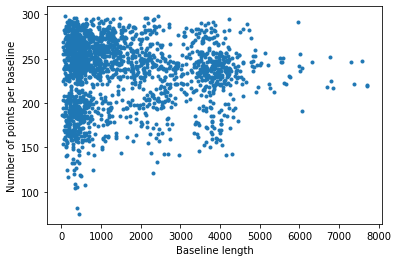

In [16]:
plt.plot(bl_len,number_of_points(Data,mon,5,tim,month=False)[0],'.')
plt.xlabel('Baseline length')
plt.ylabel('Number of points per baseline')
plt.show()

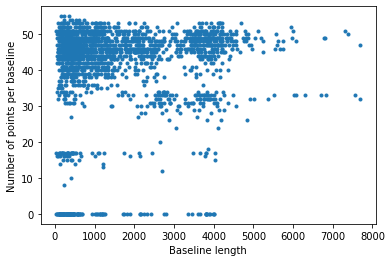

In [17]:
# Nice visualization
plt.plot(bl_len,number_of_points(Data,mon,9,tim,month=True)[0],'.')
plt.xlabel('Baseline length')
plt.ylabel('Number of points per baseline')
plt.show()

In [18]:
c = number_of_points(Data,mon,9,tim,month=True)[0]

In [19]:
def mean(obs,t):
    bl_slc = np.zeros((3,2016))
    missing = []
    tme = []
    for i in range(2016):
        ii = np.argwhere(~np.isnan(obs[:,i]))
        dd = obs[:,i][ii]
        
        if np.sum(dd)==0 or len(dd)<3:
            missing.append(i)
            tme.append(0)
            pass
        else:
            bl_slc[:,i] = dd[np.random.choice(len(dd), size=3, replace=False)].ravel()
            tme.append(t[ii][np.random.choice(len(dd), size=3, replace=False)])
    
    bl_prob = np.array([np.sum(bl_slc[:,i]*(tme[i]/(np.sum(tme[i]))).ravel()) for i in range(2016)])

    weigted = np.nanmean(bl_prob[np.isfinite(bl_prob)])
    mm = np.nanmean(bl_slc,axis=0)  
    st = np.zeros((3,2016))
    for i in range(2016):
        for j in range(len(bl_slc[:,i])):
            st[j,i] = (bl_slc[:,i][j] - mm[i])**2
            
    std = np.array([np.sqrt(np.sum(st[:,i].ravel())) for i in range(2016)])
    m = np.nanmean(mm[np.isfinite(mm)])    
    return m,weigted,std
    

In [20]:
std = [mean(number_of_points(Data,mon,i,tim,month=True)[1],number_of_points(Data,mon,i,tim,month=True)[2])[2] for i in np.unique(mon)] 

/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
stds =[ np.std(i) for i in std]
   

In [22]:
prob_mon = [mean(number_of_points(Data,mon,i,tim,month=True)[1],number_of_points(Data,mon,i,tim,month=True)[2])[0] for i in np.unique(mon)] 

/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [23]:
w_mean = [mean(number_of_points(Data,mon,i,tim,month=True)[1],number_of_points(Data,mon,i,tim,month=True)[2])[1] for i in np.unique(mon)] 

/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/isaac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


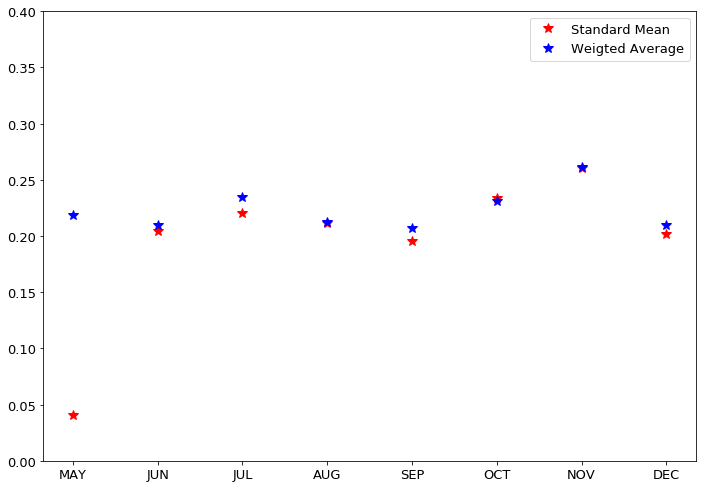

In [119]:
plt.plot(np.unique(mon)[1:],prob_mon[1:],'r*',ms=10,label='Standard Mean')
plt.plot(np.unique(mon)[1:],w_mean[1:],'b*',ms=10,label='Weigted Average')
plt.xticks([5,6,7,8,9,10,11,12],['MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.ylim(0,0.4)
plt.legend()
plt.show()

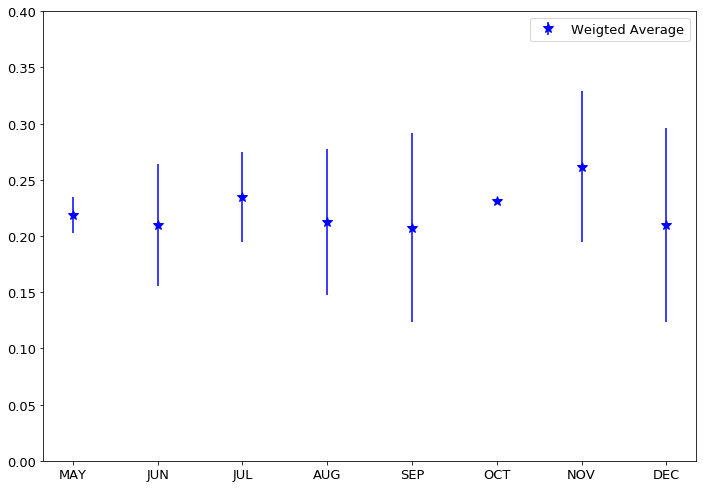

In [120]:
#plt.errorbar(np.unique(mon)[1:],prob_mon[1:],yerr=stds[1:],fmt='r*',ms=10,label='Standard Mean')
plt.errorbar(np.unique(mon)[1:],w_mean[1:],yerr=stds[1:],fmt='b*',ms=10,label='Weigted Average')
plt.xticks([5,6,7,8,9,10,11,12],['MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.ylim(0,0.4)
plt.legend()
plt.show()

In [121]:
a = np.zeros(8)

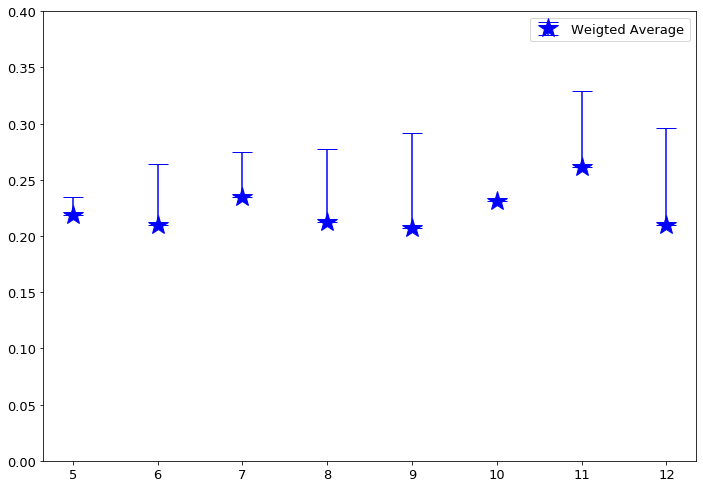

In [122]:
(_, caps, _) =plt.errorbar(np.unique(mon)[1:],w_mean[1:],yerr=[a,stds[1:]],fmt='b*',ms=20,label='Weigted Average',
                           capsize=10)

for cap in caps:
    cap.set_markeredgewidth(1)
plt.ylim(0,0.4)
plt.legend()
plt.show()